## Cluster trees function

In [1]:
using JuMP, Gurobi, GLM, DataFrames, Plots, Clustering

In [72]:
function get_parent_nodes(num_nodes)
    
    # Compute the parent nodes and paths through the tree for all nodes.
    # Nodes are numbered 1:N starting top to bottom and left to right
    # e.g.
    #     1
    #  2    3
    # 4 5  6 7
    
    if num_nodes < 1
        throw(ArgumentError("Number of nodes must be greater than 1"))
    end
    
    direct_parent = Dict()
    direct_parent[1] = []
    left_parents = Dict()
    left_parents[1] = []
    right_parents = Dict()
    right_parents[1] = []


    for node in 2:num_nodes
        par = Int(floor(node/2))
        direct_parent[node] = par
        if (par == node/2)
            left_parents[node] = push!(copy(left_parents[par]), par)
            right_parents[node] = right_parents[par]
        else
            right_parents[node] = push!(copy(right_parents[par]), par)
            left_parents[node] = left_parents[par]
        end
    end
    return direct_parent, left_parents, right_parents
end

get_parent_nodes (generic function with 1 method)

In [121]:
num_tree_nodes(depth) = 2^(depth+1)-1

function get_branch_leaf_sets(num_nodes)
    # Return the node numbers for the interior and leaf nodes
    Branches = 1:2^(max_depth)-1
    Leaves = 2^(max_depth):num_nodes
    return Branches, Leaves
end

get_branch_leaf_sets (generic function with 1 method)

In [227]:
function calculate_epsilon(X,n)
    # Calculate the epsilon used to make the splitting constraints
    # valid (otherwise we get < constraints)
    ϵ = zeros(p)
    for j = 1:p
        sXj = sort(X[:,j])
        diffs = sXj[2:end]-sXj[1:end-1]
        ϵ[j] = minimum(diffs[:,diffs != 0])
    end
    
    ϵ_mx = maximum(ϵ)
    return ϵ, ϵ_mx
endeps

calculate_epsilon (generic function with 1 method)

In [252]:
loss_normalization_factor(X) = sum(abs.(X .- mean(X,1)))

loss_normalization_factor (generic function with 1 method)

In [271]:
function ClusterTree(X,c_p,max_depth,K)
    
    # Pre-compute various model factors
    num_nodes = num_tree_nodes(max_depth)
    Branches, Leaves = get_branch_leaf_sets(num_nodes)
    direct_parent, left_parents, right_parents = get_parent_nodes(num_nodes)
    n,p = size(X)
    ϵ, ϵ_max = calculate_epsilon(X,n)
    L_s = loss_normalization_factor(X)
    
    mod = Model(solver = GurobiSolver(OutputFlag=0))

    # Split Variables
    @variable(mod, a[j=1:p,t in Branches], Bin)
    @variable(mod, b[t in Branches] >= 0)
    @variable(mod, z[i=1:n,t in Leaves], Bin)

    # Split constraints enforce all parent splits for a leaf for each point in that leaf
    for leaf in Leaves
        @constraint(mod, [i=1:n,m in left_parents[leaf]], 
            sum(a[j,m]*(X[i,j]+ϵ[j]) for j = 1:p) <= b[m] + (1+ϵ_max)*(1-z[i,leaf]))
        @constraint(mod, [i=1:n,m in right_parents[leaf]], 
            sum(a[j,m]*X[i,j] for j = 1:p) >= b[m] - (1-z[i,leaf])) 
    end
    
    @constraint(mod, each_point_one_leaf[i=1:n], 
        sum(z[i,t] for t in Leaves) == 1)
    
    # Complexity Variables
    @variable(mod, d[t in Branches], Bin)
    
    # Complexity constraints
    @constraint(mod, MakeSplit1[t in Branches], 
        sum(a[j,t] for j=1:p) == d[t])
    @constraint(mod, MakeSplit2[t in Branches], 
        b[t] <= d[t])
    for t in setdiff(Branches,1)
        @constraint(mod, d[t] <= d[direct_parent[t]])
    end
    
    # Cluster Variables
    @variable(mod, μ[k = 1:K, j=1:p])
    @variable(mod, β[t in Leaves, j=1:p])
    @variable(mod, w[k = 1:K, t in Leaves], Bin)
    @variable(mod, f[i = 1:n, j = 1:p])
    
    @variable(mod, α[t in Leaves, j=1:p, k = 1:K] >= 0)
    @variable(mod, γ[t in Leaves, j=1:p, i = 1:n] >= 0)
    
    
    # Cluster Constraints ----------FIX
    for t in Leaves
        @constraint(mod, [j=1:p], β[t,j] <= d[direct_parent[t]])
    end
    
    @constraint(mod, LinearizeMean1[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] <= w[k,t])
    @constraint(mod, LinearizeMean2[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] <= μ[k,j])
    @constraint(mod, LinearizeMean3[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] >= μ[k,j]-(1-w[k,t]))
    @constraint(mod, Mean[t in Leaves, j=1:p],
        sum(α[t,j,k] for k = 1:K) == β[t,j])
    
    @constraint(mod, wConst[t in Leaves], 
        sum(w[k,t] for k = 1:K) == 1)
    
    @constraint(mod, LinearizePred1[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] <= z[i,t])

    @constraint(mod, LinearizePred2[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] <= β[t,j])

    @constraint(mod, LinearizePred3[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] >= β[t,j]-(1-z[i,t]))
     
    @constraint(mod, Pred[i = 1:n, j=1:p],
        sum(γ[t,j,i] for t in Leaves) == f[i,j])
    
    # Loss Variables
    @variable(mod, L[i = 1:n, j = 1:p] >= 0)
    
    # Loss Constraints
    @constraint(mod, Loss1[i = 1:n, j = 1:p], 
        L[i,j] >= f[i,j]-X[i,j])   
    @constraint(mod, Loss2[i=1:n, j=1:p], 
        L[i,j] >= -f[i,j]+X[i,j])   
    
    @objective(mod, Min, (1/L_s)*sum(L[i,j] for i=1:n, j=1:p) + 
        c_p*sum(d[t] for t in Branches));

    status = solve(mod)
    println("Status = ", status)
    return Dict("z" => getvalue(z), "μ" => getvalue(μ),
                "a" => getvalue(a), "b" => getvalue(b),
                "d" => getvalue(d), "w" => getvalue(w),
                "obj" => getobjectivevalue(mod))
end;

## Generate test data and visualize clustering

In [371]:
function create_synthetic_data(n,μ,σ;seed = 1234)
    srand(seed)
    X = (μ[1].+σ[1]*randn(n[1],2)')'
    for i = 2:size(n)[1]
        new_x = (μ[i].+σ[i]*randn(n[i],2)')'
        X = vcat(X,new_x)
    end
    return X
end

function synthetic_data_cluster_assignments(n)
    Y = ones(Int, n[1],1)
    for i = 2:size(n)[1]
        y = i*ones(Int,n[i],1)
        Y = vcat(Y,y)
    end
    return Y
end

function feature_scaling(X;method = "scale")
    if method == "scale"
        mx_X = maximum(X,1)
        mn_X = minimum(X,1)
        return (X .- mx_X)./(mn_X .- mx_X)
    elseif method == "normalize"
        mu = mean(X,1)
        sigma = std(X,1)
        return (X .- mu) ./ sigma
    else
        throw(ArgumentError("method must be 'scale' or 'normalize' "))
    end
end    

feature_scaling (generic function with 1 method)

In [383]:
n = [10,10,8,8]
μ = [[10,10],[0,5],[10,0],[5,5]]
σ = [1/1.9, 1/1.5, 1/0.9, 1/0.9]
X = create_synthetic_data(n,μ,σ)
Xnor = feature_scaling(X)
Y = synthetic_data_cluster_assignments(n);

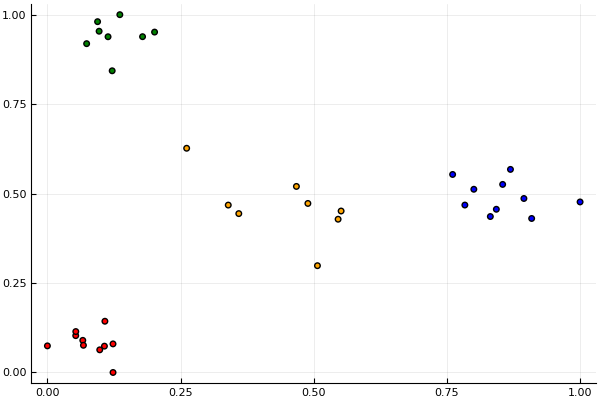

In [384]:
mcols = [:red, :blue, :green, :orange]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[Y], leg=false)

In [385]:
c_p = 0
max_depth = 2
K = 4
result = ClusterTree(Xnor,c_p,max_depth,K);

Academic license - for non-commercial use only
Status = Optimal


In [386]:
which_t = [find(result["z"][i,:])[1] for i = 1:sum(n)]
t_to_k = [find(result["w"][:,:][:,i])[1] for i = 1:length(result["w"][1,:])]
assigments = t_to_k[which_t];

In [387]:
t_mx = 2^(max_depth+1)-1
t = 1:t_mx
Branches = t[1:2^(max_depth)-1]
Leaves = t[2^(max_depth):end];

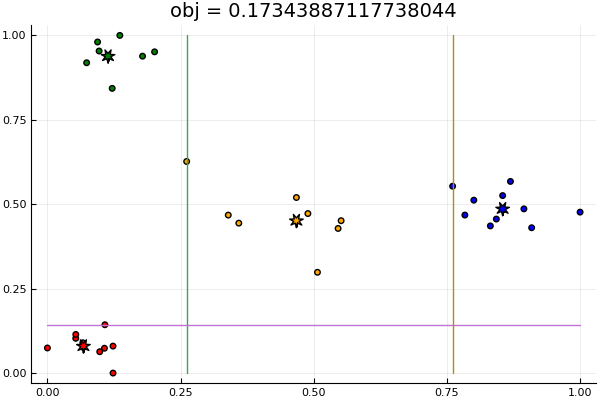

In [388]:
mcols = [:red, :blue, :green, :orange]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[assigments], 
    leg=false, title = "obj = $obj")
scatter!(result["μ"][:,1],result["μ"][:,2], markercolor=mcols, m=[:star7], markersize = 10)

p = 2
for t in Branches
    if (result["a"][1,t] > 0) # Vertical Split
        xs = result["b"][t]*ones(100)
        ys = linspace(0,1,100)
    else              # Horizontal Split
        xs = linspace(0,1,100)
        ys = result["b"][t]*ones(100)
    end
    plot!(xs,ys)
end

plot!()

## Visualize tree